[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aunz/ds/blob/master/KNN.ipynb)

# k Nearest Neighbors


We will implement k nearest neighbors in Python and hopefully at the end of this notebook, you will understand how KNN works.

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import the iris dataset from sklearn
iris = __import__('sklearn').datasets.load_iris()

# overview of the data
print('Number of observation: {}\nNumber of feature: {}'.format(*iris.data.shape))
print('Target category:', iris.target_names)
pd.DataFrame(iris.data, columns=iris.feature_names, index=iris.target).head(10)

Number of observation: 150
Number of feature: 4
Target category: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
0,4.9,3.0,1.4,0.2
0,4.7,3.2,1.3,0.2
0,4.6,3.1,1.5,0.2
0,5.0,3.6,1.4,0.2
0,5.4,3.9,1.7,0.4
0,4.6,3.4,1.4,0.3
0,5.0,3.4,1.5,0.2
0,4.4,2.9,1.4,0.2
0,4.9,3.1,1.5,0.1


In this dataset, there are:
- 150 observations
- 4 features: sepal length, sepal width, petal length, petal width
- 3 species of flower in the dataset: Setosa (0), Versicolor (1), Virginica (2). 

From the graphs below, we can see that each species can be more or less clustered together using various features. For example, setosa has smaller petal septal length, petal length and petal width compared to the other two species.

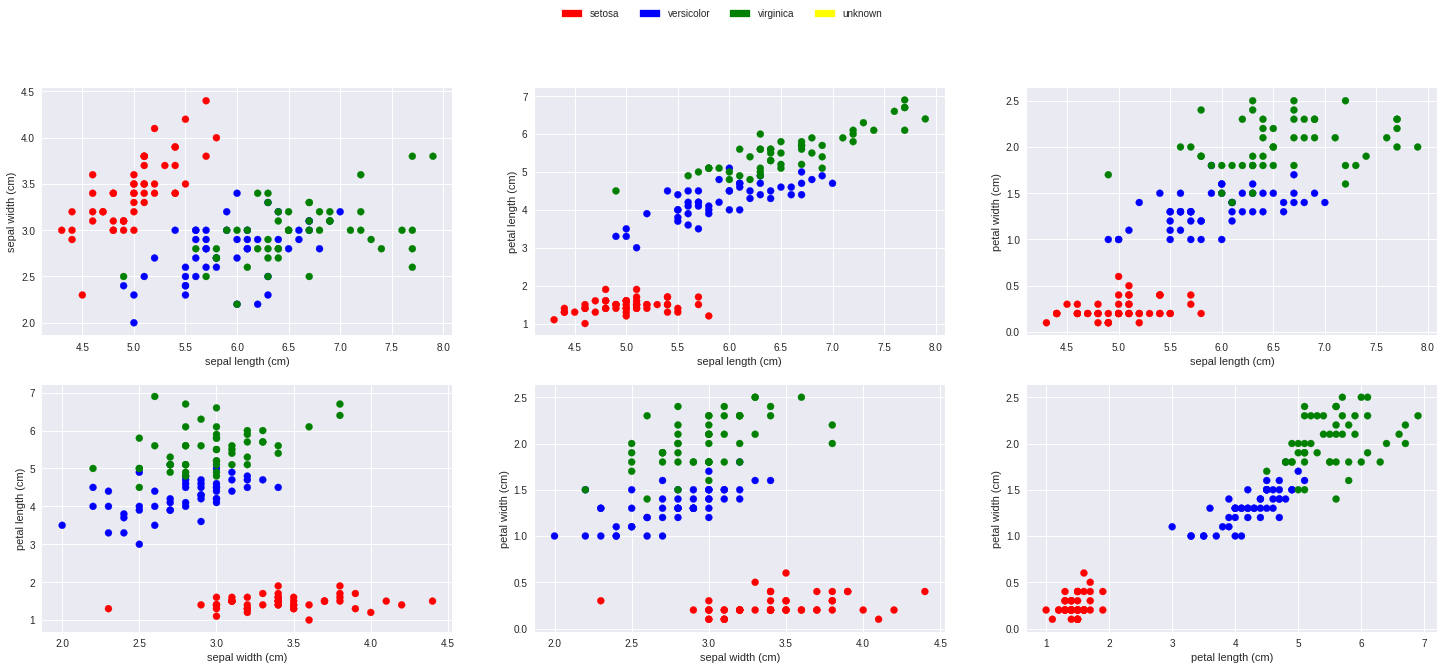

In [128]:
# a helper function to plot
def plot(ax, x1, x2):
    colors = list(map(lambda x: { 0: 'red', 1: 'blue', 2: 'green', 3: 'yellow' }[x], iris.target))
    ax.scatter(iris.data[:, x1], iris.data[:, x2], c=colors)
    ax.set_xlabel(iris.feature_names[x1])
    ax.set_ylabel(iris.feature_names[x2])

fig, ax = plt.subplots(2, 3, figsize=(25, 10))
plot(ax[0][0], 0, 1)
plot(ax[0][1], 0, 2)
plot(ax[0][2], 0, 3)
plot(ax[1][0], 1, 2)
plot(ax[1][1], 1, 3)
plot(ax[1][2], 2, 3)

fig.legend(handles=[
    mpatches.Patch(color='red', label=iris.target_names[0]),
    mpatches.Patch(color='blue', label=iris.target_names[1]),
    mpatches.Patch(color='green', label=iris.target_names[2]),
    mpatches.Patch(color='yellow', label='unknown'),
], loc='upper center', ncol=4);


The question is: given a sample without a label, can we classify it using its features?

The graph on the left below shows 4 such new samples, can you guess their labels?
- Sample 1 is close to Setosa, so it's likely to be Setosa,
- Sample 2 is close to Virginica, so it's likely to be Virginica
- Sample 3 is close to both Versicolor and Virginica, can be either
- Sample 4 is close to both Versicolor and Virginica too, can be either

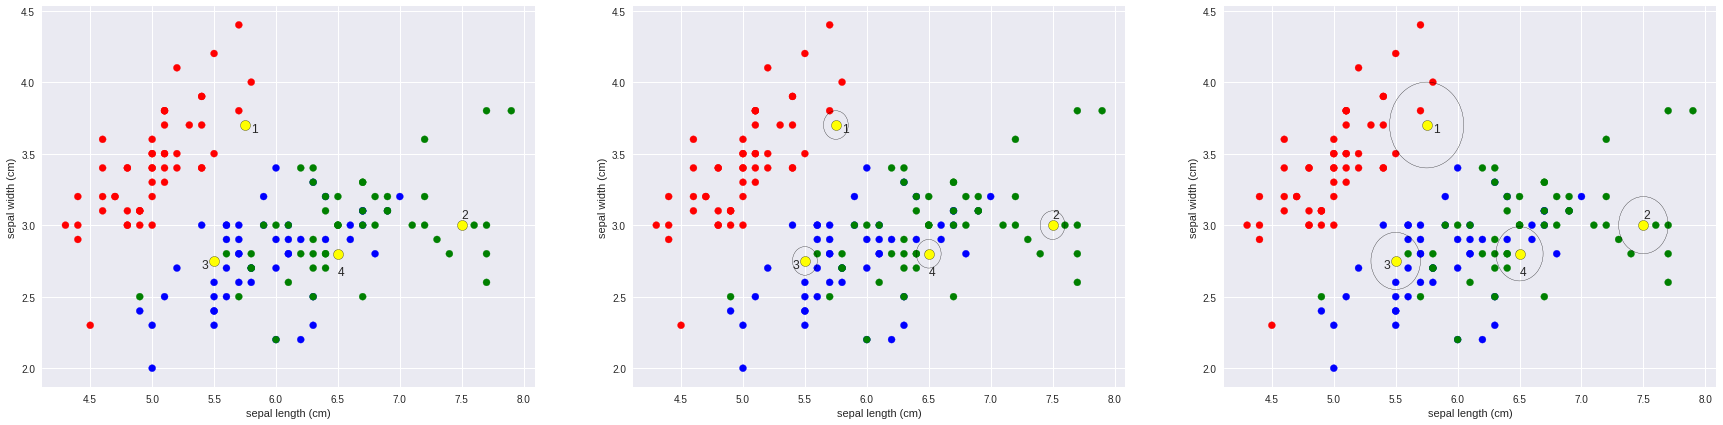

In [216]:
fig, ax = plt.subplots(1, 3, figsize=(30, 7))
for i in ax:
    plot(i, 0, 1)
    i.scatter([5.75], [3.7], c='yellow', edgecolor='black', s=100); i.text(5.8, 3.65, '1') # sample 1
    i.scatter([7.5], [3.0], c='yellow', edgecolor='black', s=100); i.text(7.5, 3.05, '2') # sample 2
    i.scatter([5.5], [2.75], c='yellow', edgecolor='black', s=100); i.text(5.4, 2.7, '3', horizontalalignment='left') # sample 3
    i.scatter([6.5], [2.8], c='yellow', edgecolor='black', s=100); i.text(6.5, 2.65, '4'); # sample 4
    
# sample 1 circles
ax[1].add_patch(mpatches.Circle(xy=(5.75, 3.7), radius=0.1, facecolor='none', edgecolor='black'))
ax[2].add_patch(mpatches.Circle(xy=(5.75, 3.7), radius=0.3, facecolor='none', edgecolor='black'))

# sample 2 circles
ax[1].add_patch(mpatches.Circle(xy=(7.5, 3.0), radius=0.1, facecolor='none', edgecolor='black'))
ax[2].add_patch(mpatches.Circle(xy=(7.5, 3.0), radius=0.2, facecolor='none', edgecolor='black'))

# sample 3 circles
ax[1].add_patch(mpatches.Circle(xy=(5.5, 2.75), radius=0.1, facecolor='none', edgecolor='black'))
ax[2].add_patch(mpatches.Circle(xy=(5.5, 2.75), radius=0.2, facecolor='none', edgecolor='black'))

# sample 4 circles
ax[1].add_patch(mpatches.Circle(xy=(6.5, 2.8), radius=0.1, facecolor='none', edgecolor='black'))
ax[2].add_patch(mpatches.Circle(xy=(6.5, 2.8), radius=0.19, facecolor='none', edgecolor='black'));

**KNN** works by finding the nearest neighbour to the sample we are interested in.

In the middle graph above, in each sample, we can draw a circle around each sample.
- In sample 1, the nearest is obviously a Setosa,
- In sample 2, the nearest is Virginica
- In sample 3, we have 2 species
- In sample 4, the nearest is Virginica

In the left graph above, we can draw a bigger around each sample.
- In sample 3, there are 4 Versicolor, 1 Virginica. So we can label this sample as Versicolor
- In sample 4, the circle encompasses 3 Virginica, 2 Versicolor. So we can lable this sample as Virginica

"Nearest" in this sense means distance. There are many ways to calculate distances, one of them is [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).

In a 2D space, the disance between point A($x_A$, $y_A$) and B($x_B$, $y_B$) is given:   
\begin{equation*}
\ distance = \sqrt{(x_A - x_B)^2 + (y_A -  y_B)^2}
\end{equation*}

In a 3D space, the disance between point A($x_A$, $y_A$, $z_A$) and B($x_B$, $y_B$, $z_B$) is given:   
\begin{equation*}
\ distance = \sqrt{(x_A - x_B)^2 + (y_A - y_B)^2 + (z_A - z_B)^2}
\end{equation*}

**Now let's code**

Firstly, define a function to calculate the distance between 2 points

In [0]:
def distance(A, B):
    # compute distance between A (np.array) and B (np.array same shape to A)
    tmp = A - B # 1, substraction
    tmp = np.power(tmp, 2) # 2, power up
    tmp = np.sum(tmp) # 3, sum
    tmp = np.sqrt(tmp) # 4, sqrt
    # tmp = np.linalg.norm(A - B) # the above 4 steps can be done using np.linalg.norm as well
    return tmp

For a given point X(6.5, 2.9, 5.0, 1.6) (sepal length, sepal width, petal length, petal width)
- calculate its distances to all the other samples.
- sort the distances from smallest to largest


In [270]:
x = np.array([6.5, 2.9, 5.0, 1.6]) # the point of interest, we want to predict its label
distances = [distance(x, i) for i in iris.data] # all the distance from point X to all the samples in the iris.data
 
# turn into dataframe for ease of display and understanding
df = pd.DataFrame({
    'distance': distances,
    'target': list(map(lambda x: { 0: 'setosa', 1: 'versicolor', 2: 'virginica' }[x], iris.target))
})

# sort them and display the first 10 rows
df.sort_values('distance', inplace=True)
df.head(10)

,distance,target
77,0.244949,versicolor
133,0.264575,virginica
123,0.360555,virginica
126,0.424264,virginica
86,0.424264,versicolor
76,0.424264,versicolor
54,0.424264,versicolor
147,0.458258,virginica
72,0.469042,versicolor
127,0.469042,virginica


We can see that the predicted targets are: setosa, setosa, versicolor, versicolor, setosa etc according to the distance.

Now the **k** in the **KNN** comes in.
- k = 1, we look at the first row, the predicted target is versicolor, 
- k = 2, we look at the first 2 rows, there are 1 versicolor, 1 virgincia, so the predicted target is a draw. It can either be versicolor or virginica, depending on the sorting of the target
- k = 3, we look at the first 3 rows, there are 1 versicolor, 2 virginica, the predicted target is virginica
- k = 4, we look at the first 4 rows, there are 1 versicolor, 3 virginica, the predicted target is virginica. 
- and so on

Let's check out the graphs. The yellow circle is the sample we are looking for.

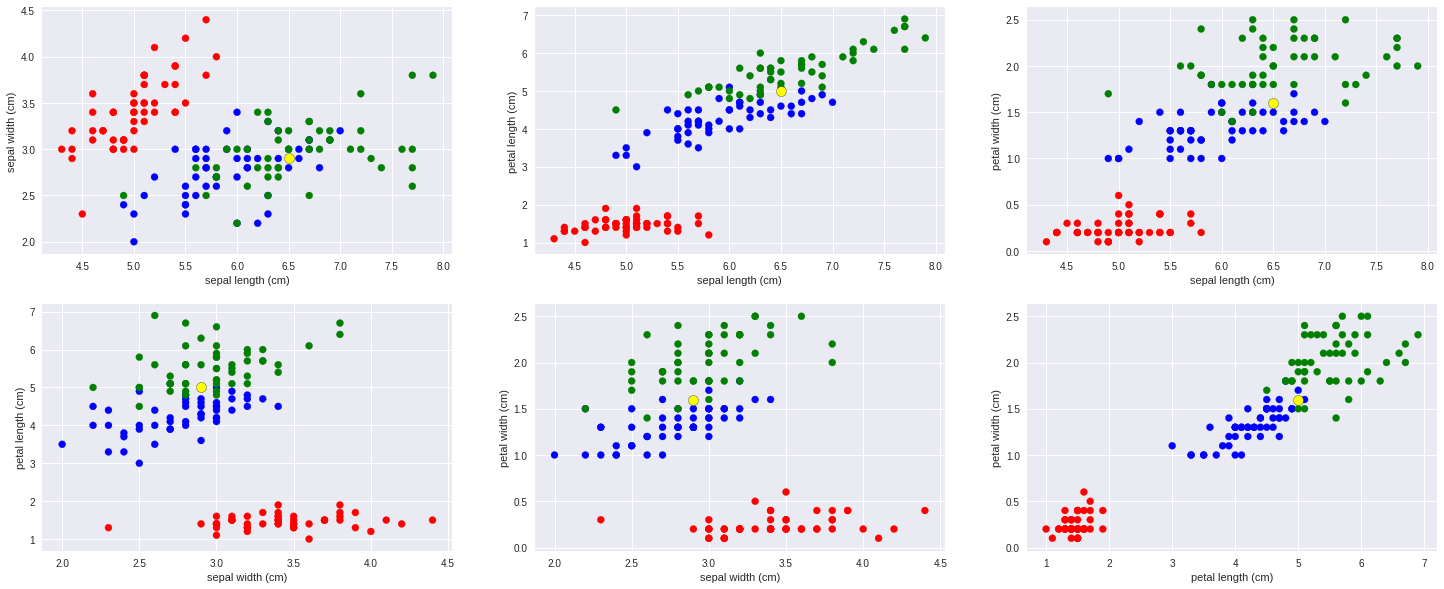

In [273]:
_, ax = plt.subplots(2, 3, figsize=(25, 10))
plot(ax[0][0], 0, 1)
plot(ax[0][1], 0, 2)
plot(ax[0][2], 0, 3)
plot(ax[1][0], 1, 2)
plot(ax[1][1], 1, 3)
plot(ax[1][2], 2, 3)
ax[0][0].scatter(x[0], x[1], c='yellow', edgecolor='black', s=100)
ax[0][1].scatter(x[0], x[2], c='yellow', edgecolor='black', s=100);
ax[0][2].scatter(x[0], x[3], c='yellow', edgecolor='black', s=100);
ax[1][0].scatter(x[1], x[2], c='yellow', edgecolor='black', s=100);
ax[1][1].scatter(x[1], x[3], c='yellow', edgecolor='black', s=100);
ax[1][2].scatter(x[2], x[3], c='yellow', edgecolor='black', s=100);

**Congrad! Now you understand KNN 🎉**

Is it very simple, isn't it! 😀

You don't actually need to do this manually, the [*scikit-learn*](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) package already implements KNN

In [287]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1) # initialise knn with k = 1 (n_neighbors)
clf.fit(iris.data, iris.target) # fit the data
print('K = 1, predict x to be:', iris.target_names[clf.predict([x])[0]]) # predict

# now do it again with different k
for i in range(2, 7):
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(iris.data, iris.target)
    print(f'K = {i}, predict x to be:', iris.target_names[clf.predict([x])[0]])

K = 1, predict x to be: versicolor
K = 2, predict x to be: versicolor
K = 3, predict x to be: virginica
K = 4, predict x to be: virginica
K = 5, predict x to be: virginica
K = 6, predict x to be: versicolor


So, what are the advantages and disadvantage in KNN?

### Pros
- No assumption about the underlying data, so it's suitable for non-linear data
- Simple to understand
- Easy to compute
- Versertile: applicable to classification and regression (taking the mean or the weighted average of the top k rows)
- Relatively high accuracy

### Cons
- Choosing K can be quite arbitrary. As you can see from the example above, different Ks give different results
- It's a "lazy learner", which means it doesn't learn anything from the dataset. Each time you need to predict a new point, it re-compute the distance between the new point with every observation in the dataset.
- Can be slow when the dataset is huge or there are many features to calculate distances
- Sensitive to localized data, as k-NN prediction gets all the information from the input's neighbors, any localized anomalies can affect results significantly
- Sensitive to outliers, irrelevant features and scales of data
- High memory requirement

